In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objs as go
import os
import gc

In [ ]:
#import for preprocessing
import re  # remove regular html tags
from string import punctuation 
from nltk.corpus import stopwords      # stopwords for filtering out useless word expression(eg. as, in, is, a, the etc.)
from scipy.spatial import distance                        # measure distance in case of calulating similarity
from nltk.stem import PorterStemmer    # to do stemming ( to find out the base words)
from nltk.stem import WordNetLemmatizer
from fuzzywuzzy import fuzz         #
from bs4 import BeautifulSoup
#from MulticoreTSNE import MulticoreTSNE as TSNE  #to visualize after dimensionality reduction
from wordcloud import WordCloud, STOPWORDS    # to get image of most occuring words
from os import path                    # to get files in os
from PIL import Image                  # to work with images
from multiprocessing import Pool       # very important to divide work in different cores
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,classification_report,f1_score,accuracy_score

In [6]:
data=pd.read_csv('questions.csv')
data.shape

(404351, 6)

In [ ]:
df=data.head(1000)
df.head()

In [ ]:
#distribution of data for different count
df['is_duplicate'].value_counts()

In [ ]:
print("length of data:",len(df))
print("shape of data:",df.shape)

In [ ]:
df.info()

In [11]:
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [12]:
df=df.fillna('')
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [13]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

# number of unique questions


In [14]:
qids=pd.Series(df['qid1'].tolist()+ df['qid2'].tolist())
print(qids)
unique_qs=len(np.unique(qids))
qs_morethan_onetime=np.sum(qids.value_counts()>1)
print("total number of unique questions are:{}\n".format(unique_qs))
print("the total number of question occur more than one time:{} \n".format(qs_morethan_onetime))
print("maximum number of time a question is repeated: {}\n".format(max(qids.value_counts())))
print("minimum number of times the question is repeated: {}\n".format(min(qids.value_counts())))


0            1
1            3
2            5
3            7
4            9
         ...  
39995    39898
39996    39900
39997    39902
39998    39904
39999    39906
Length: 40000, dtype: int64
total number of unique questions are:39906

the total number of question occur more than one time:91 

maximum number of time a question is repeated: 3

minimum number of times the question is repeated: 1



F:\New folder\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


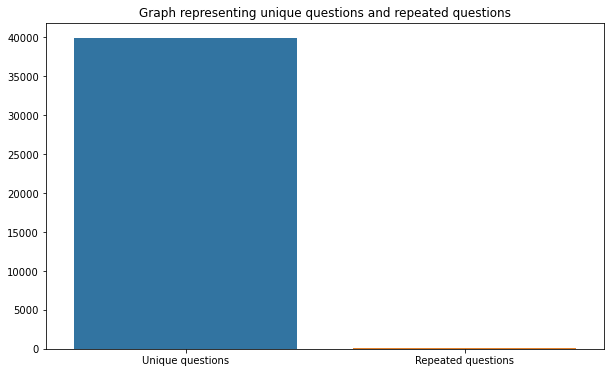

In [15]:
x=["Unique questions","Repeated questions"]
y=[unique_qs,qs_morethan_onetime]
plt.figure(figsize=(10,6))
plt.title("Graph representing unique questions and repeated questions")
sns.barplot(x,y)
plt.show()

In [16]:
df.loc[1]

id                                                              1
qid1                                                            3
qid2                                                            4
question1       What is the story of Kohinoor (Koh-i-Noor) Dia...
question2       What would happen if the Indian government sto...
is_duplicate                                                    0
Name: 1, dtype: object

In [29]:
SPECIAL_TOKENS = {'non-ascii': 'non_ascii_word'}
def normalized_word(text,stem_words=True):
    def pad_str(s):
        return ' '+s+' ' 
    if pd.isnull(text):     # if null
        return ''
    #Empty question
    if type(text)!=str or text==' ':
        return ''
    text=re.sub("\'s"," ",text)    # there are 2 cases sachin is and sachin's(his), these are not sererable and choose to kill 's'
    #text=re.sub("\'ve","have",text)  
    text=re.sub("whats","what is",text,flags=re.IGNORECASE)    # USE FLAG=IGNORECASE TO MAKE IT CASE INSENSITIVE
    text=re.sub("n't","not",text)               #replace n't to not
    text=re.sub("won't","will not",text,flags=re.IGNORECASE)
    text=re.sub("i'm","i am",text,flags=re.IGNORECASE)
    #text=re.sub("\'re","are",text)
    text=re.sub("can't","can not",text)
    text=re.sub("\'d","would",text)
    #text=re.sub("e\.g\."," eg ",text,flags=re.IGNORECASE)
    text=re.sub("b\.g\."," bg ",text,flags=re.IGNORECASE)
    #text=re.sub("e-mail","email",text,flags=re.IGNORECASE)
    text=re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.","America",text,flags=re.IGNORECASE)
    text=re.sub("(the[\s]+|The[\s]+)?Unites State(s)?","America",text,flags=re.IGNORECASE)
    text=re.sub("\(s\)","",text)
    #text=re.sub("[c-fC-F]\:\/"," disk ",text)
    text=re.sub('(?<=[0-9])\,(?=[0-9])',"",text)      # remove comma between numbers like 15,000-> 15000
    ###add padding to punctuations and special chars
    text=re.sub('\$',"dollar",text)
    text=re.sub('\%',"percent",text)
    text=re.sub('\&',"and",text)
    #text=re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) 
    #indian currency
    text=re.sub("(?<=[0-9])rs","rs",text,flags=re.IGNORECASE)
    text=re.sub("rs(?=[0-9])","rs",text,flags=re.IGNORECASE)
    ## #cleaning text rules
    #text=re.sub(r"(the[\s]+|The[\s]+)?US(A)?","America",text,flags=re.IGNORECASE)
    text=re.sub(r"UK","England",text,flags=re.IGNORECASE)
    text=re.sub(r"switzerland","Switzerland",text,flags=re.IGNORECASE)
    #text=re.sub(r"india","India",text)
    text=re.sub(r"china","China",text)
    text=re.sub(r"chinese","Chinese",text)
    text=re.sub(r"imrovement","improvement",text)
    text=re.sub(r"intially","initially",text)
    text=re.sub(r"quora","Quora",text,flags=re.IGNORECASE)
    text=re.sub(r"dms","direct message",text,flags=re.IGNORECASE)
    text=re.sub(r"actived","active",text,flags=re.IGNORECASE)
    text=re.sub(r"cs","computer science",text,flags=re.IGNORECASE)
    text=re.sub(r"demonitization","demonetization",text,flags=re.IGNORECASE)
    text=re.sub(r"kms","kilometers",text,flags=re.IGNORECASE)
    text=re.sub(r"upvote","up vote",text,flags=re.IGNORECASE)
    text=re.sub(r"iPhone","phone",text,flags=re.IGNORECASE)
    text=re.sub(r"\0rs","rs",text,flags=re.IGNORECASE)
    text=re.sub(r"ios","IOS",text,flags=re.IGNORECASE)
    text=re.sub(r"gps","GPS",text,flags=re.IGNORECASE)
    text=re.sub(r"gst","GST",text,flags=re.IGNORECASE)
    text=re.sub(r"programing","programming",text,flags=re.IGNORECASE)
    text=re.sub(r"bestfriend","best friend",text,flags=re.IGNORECASE)
    text=re.sub(r"dna","DNA",text,flags=re.IGNORECASE)
    text=re.sub(r"banglore","Banglore",text,flags=re.IGNORECASE)
    text=re.sub(r"III","3",text)
    text=re.sub(r" J K ","JK",text,flags=re.IGNORECASE)
    text=re.sub(r" J\.K\.","JK",text,flags=re.IGNORECASE)
    ##replace the float number with random number
    text=re.sub(r"[0-9]+\.[0-9]+","87",text)
    
    ##removing punctuations
    text=[word for word in text if word not in punctuation]
    text=''.join(text)
    text=text.lower()
    ##return a list of words
    return text

In [32]:
pair_duplicates=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2','is_duplicate'])
print("number of duplicate questions".format(pair_duplicates.shape(0)))
                   

AttributeError: 'DataFrameGroupBy' object has no attribute 'shape'

C:\Users\SGCOMP~1\AppData\Local\Temp/ipykernel_2028/582596669.py:3: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log',nonposy='clip')


maximum time repeatition of any question is:3



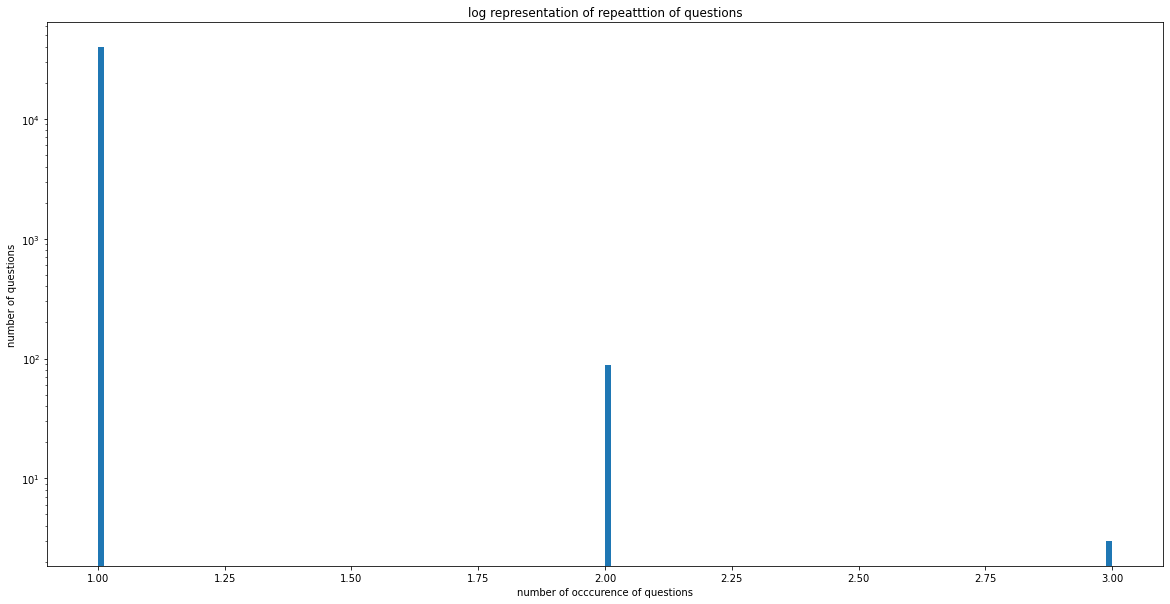

In [17]:
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins=170)
plt.yscale('log',nonposy='clip')
plt.title("log representation of repeatttion of questions" )
plt.xlabel("number of occcurence of questions")
plt.ylabel("number of questions")
print("maximum time repeatition of any question is:{}\n".format(max(qids.value_counts())))

In [19]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df=pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin')
else:
    df['freq_id1']=df.groupby('qid1')['qid1'].transform('count')
    df['freq_id2']=df.groupby('qid2')['qid2'].transform('count')
    df['q1len']=df['question1'].str.len()
    df['q2len']=df['question2'].str.len()
    df['q1_n_words']=df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words']=df['question2'].apply(lambda row: len(row.split(" ")))
    
    def normalized_word_common(row):
        w1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)
    df['word_common']=df.apply(normalized_word_common,axis=1)
    
    def normalized_word_total(row):
        w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
        return 1.0* (len(w1) + len(w2))
    df['word_total']=df.apply(normalized_word_total,axis=1)
    
    def normalized_word_share(row):
        w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
        return 1.0* len(w1 & w2)/(len(w1)+len(w2))
    df['word_share']=df.apply(normalized_word_share,axis=1)
    
    df.to_csv("df_fe_without_preprocessing_train.csv",index=False)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1_len,q2_len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


In [21]:
print("minimum number of words in question in question1",min(df['q1_n_words']))
print("minimum number of words in question in question2",min(df['q2_n_words']))
print("number of questions with minimum length in question1",df[df['q1_n_words']==1].count())
print("number of quetions with minimum length in question2",df[df['q2_n_words']==1].count())

minimum number of words in question in question1 1
minimum number of words in question in question2 1
number of questions with minimum length in question1 id              60
qid1            60
qid2            60
question1       59
question2       60
is_duplicate    60
freq_qid1       60
freq_qid2       60
q1_len          60
q2_len          60
q1_n_words      60
q2_n_words      60
word_common     60
word_total      60
word_share      60
freq_q1+q2      60
freq_q1-q2      60
dtype: int64
number of quetions with minimum length in question2 id              25
qid1            25
qid2            25
question1       25
question2       23
is_duplicate    25
freq_qid1       25
freq_qid2       25
q1_len          25
q2_len          25
q1_n_words      25
q2_n_words      25
word_common     25
word_total      25
word_share      25
freq_q1+q2      25
freq_q1-q2      25
dtype: int64


## data preprocessing
   remove html tags
   removre punctuations
   remove stopwords
   perform stemming
   expand contractions

In [45]:
SAFE_DIV=0.0001
STOP_WORDS=stopwords.words("english")

def preprocess(x):
    x=str(x).lower()
    x=x.replace(",000,000","m").replace(",000","k").replace("%","percent").replace("₹","rupee").replace("€",'euro').replace("&","and").replace("$","dollar").replace("won't","will not").replace("can't","can not").replace("n't","not").replace("'ve","have").replace("he's","he is").replace("i'm","i am").replace("she's","she is").replace("what's","what is")
    
    x=re.sub(r"([0-9]+)000000",r"\1m",x)
    x=re.sub(r"([0-9]+)000",r"\1k",x)
    
    porter=PorterStemmer()
    pattern=re.compile('\W')
    
    if type(x)==type(''):
        x=re.sub(pattern,' ',x)
        
    if type(x)==type(''):
        x=porter.stem(x)
        example1=BeautifulSoup(x)
        x=example1.get_text()
        
    return x

In [22]:
def get_token_features(q1,q2):
    token_features=[0.0] * 10
    #converting the tokens from sentence
    q1_token=q1.split()
    q2_token=q2.split()
    if len(q1_token)==0 or len(q2_token)==0:
        return token_feature
    # get word not in stopword from token
    q1_words=set([word for word in q1_token if word not in STOP_WORDS])
    q2_words=set([word for word in q2_token if word not in STOP_WORDS])
    #get stopwords from tokens
    q1_stop=set([word for word in q1_token if word in STOP_WORDS])
    q2_stop=set([word for word in q2_token if word in STOP_WORDS])
    common_word_count=len(q1_words.intersection(q2_words))
    common_stop_count=len(q1_stop.intersection(q2_stop))
    # get common tokens from question pair
    common_token_count=len(set(q1_token).intersection(set(q2_token)))
    
    token_features[0]=common_word_count/(min(len(q1_words),len(q2_words))+SAFE_DIV)
    token_features[1]=common_word_count/(max(len(q1_words),len(q2_words))+SAFE_DIV)
    token_features[2]=common_stop_count/(min(len(q1_stop),len(q2_stop))+SAFE_DIV)
    token_features[3]=common_stop_count/(max(len(q1_stop),len(q2_stop))+SAFE_DIV)
    token_features[4]=common_token_count/(min(len(q1_stop),len(q2_stop))+SAFE_DIV)
    token_features[5]=common_token_count/(max(len(q1_stop),len(q2_stop))+SAFE_DIV)
    
    #last word of both question is sme or not
    token_features[6]=int(q1_token[-1]==q2_token[-1])
    #first word of token is same or not
    token_features[7]=int(q1_token[0]==q2_token[0])
    
    token_features[8]=abs(len(q1_token)-len(q2_token))
    #average of length of both questions
    token_features[9]=(len(q1_token)+len(q2_token))/2
    return token_features

def common_longest_substring(a,b):
    strs=list(distance.lcsubstrings(a,b))
    if len(strs)==0:
        return 0
    else:
        return len(strs[0])/min(len(a),len(b)+1)
def extract_features(df):
    df['question1']=df['question1'].fillna("").apply(preprocess)
    df['question2']=df['question2'].fillna("").apply(preprocess)
    print("token fratures...")
    df['cwc_min']=list(map(lambda x: x[0],token_features))
    df['cwc_max']=list(map(lambda x: x[1],token_features))
    df['csc_min']=list(map(lambda x: x[2],token_features))
    df['csc_max']=list(map(lambda x: x[3],token_features))
    df['ctc_min']=list(map(lambda x: x[4],token_features))
    df['ctc_max']=list(map(lambda x: x[5],token_features))
    df['last_word_eq']=list(map(lambda x: x[6],token_features))
    df['first_word_eq']=list(map(lambda x: x[7],token_features))
    df['abs_len_diff']=list(map(lambda x: x[8],token_features))
    df['mean_len']=list(map(lambda x:x[9],token_features))
    
    print("fuzzy features...")
    df['token_set_ratio']=df.apply(lambda x: fuzz.token_set_ratio(x['question1'],x['question2']),axis=1)
    df['token_sort_ratio']=df.apply(lambda x: fuzz.token_sort_ratio(x['question1'],x['question2']),axis=1)
    df['fuzz_ratio']=df.apply(lambda x: fuzz.QRatio(x['question1'],x['question2']),axis=1)
    df['fuzz_partial_ratio']=df.apply(lambda x: fuzz.partial_ratio(x['question1'],x['question2']),axis=1)
    df['longest_substr_ratio']=df.apply(lambda x: fuzz.get_longest_substr.ratio(x['question1'],['question2']),axis=1)
    return df


In [23]:
def parallelize_dataframe(df,func,n_cores=4):
    df_split=np.array_split(df,n_cores)
    pool=Pool(n_cores)
    df=pd.concat(pool.map(func,df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
print("extracing features....")
df=pd.read_csv("questions.csv")
parallelize_dataframe(df,extract_features)
df.to_csv("nlp_features_train.csv")
df.head()

extracing features....


## analysis of extracted features

In [ ]:
df_duplicate=df[df[is_duplicate]==1]
df_notduplicate=df[df[is_duplicate]==0]
# flat the 2d array 
p=np.dtack([df_duplicate['question1'],df_duplicate['question2']]).flatten()
n=np.dstack([df_notduplicate['question1'],df_notduplicate['question2']]).flatten()
print("number of data points in duplicate class:",len(p))
print("number of data points in non_duplicate class:",len(n))
#saving the txt file into txt
np.savetxt('train_p.txt',p,delimiter=(' '),fmt='%s')
np.savetxt('train_n.txt',p,delimiter=(' '),fmt='%s')

In [ ]:
d=path.dirname(".")
textp_w=open(path.join(d,"train_p.txt")).read()
textn_w=open(path.join(d,"train_n.txt")).read()
stopwords=set(STOP_WORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")
print("total number of words in duplicate pair questions:",len(textp_w))
print("total number of words in non-duplicate pair questions:",len(textn_w))

In [ ]:
wc=WordCloud(background_color='white',max_words=len(textp_w),stopwords=stopwords)
wc.generate(textp_w)
print("wordcloud for duplicate question pairs")
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
wc=WordCloud(background_color='white',max_words=len(textn_w),stopwords=stopwords)
wc.generate(textn_w)
print("wordcloud for no duplicate queston pair")
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
a=np.array([1,2,3,4])
print(a[False,True])

In [ ]:
import math
print(math.pow(2,10))